In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import matplotlib as mpl
import numpy as np
# import cmocean
from glob import glob
import os
from tqdm.notebook import tqdm, trange
import shutil
import pyfftw
import peakutils
import multiprocessing as mp
import time
import cv2
from pyzfn import Pyzfn as op
from pyzfn import utils
import re
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
utils.load_mpl_style(skip_style=False)
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [ ]:
!pip install cmocean

In [ ]:
path="/home/users/kkingstoun/grant_398/scratch/mateuszz/ReCoPt/systematic/v4"

In [2]:
class pp:
    def __init__(self, root_path):
        self.root_path = Path(root_path)
        self.folder_list = None

    def _is_zarr_folder(self, path):
        return path.is_dir() and path.name.endswith('.zarr')

    def find_zarr_folders(self):
        zarr_folders = []
        with ThreadPoolExecutor(max_workers=10) as executor:  # Ograniczamy liczbę wątków
            futures = {executor.submit(self._is_zarr_folder, path): path for path in self.root_path.rglob('*')}
            for future in futures:
                if future.result():
                    zarr_folders.append(str(futures[future]))

        self.folder_list = sorted(zarr_folders)
        return self.folder_list


In [ ]:
p = pp(path)
zarr_folders = p.find_zarr_folders()

In [ ]:
job = op(p.folder_list[220])

In [ ]:
mz = job.table.mz[:]

In [ ]:
job.table.B_extz

In [ ]:
b_extz = job.table.B_extz[:]

In [ ]:
plt.figure()
plt.plot(b_extz,mz[::])

# plt.plot(mz[::])
plt.plot(b_extz[::1500],mz[::1500])

In [ ]:
data = np.genfromtxt("./jobs/mateusz/hystersisis/out_of_plane.dat",delimiter="\t",skip_header=0)
print(data[:,0])

In [3]:
def _extract_params(folder_path):
    folder_name = Path(folder_path.split("/")[-1]).name  # Używamy tylko ostatniej części ścieżki
    params = {}

    # Ekstrakcja parametrów z nazwy pliku (ostatniego elementu ścieżki)
    file_params = folder_name.rstrip('.zarr').split('_')
    for param in file_params:
        if ':' in param:
            key, value = param.split(':', 1)
            try:
                params[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
            except ValueError:
                params[key] = value
        elif param.startswith('sim'):
            params['sim'] = int(folder_name.split("_ku")[0].split("sim_")[-1])

    return params

_extract_params(zarr_folders[0])


NameError: name 'zarr_folders' is not defined

In [ ]:
class HysteresisData:
    def __init__(self, zarr_folders=None, data_file=None):
        if data_file:
            self.data = pd.read_csv(data_file)
        elif zarr_folders:
            self.data = self._load_data_from_folders_parallel(zarr_folders)
        else:
            raise ValueError("Either zarr_folders or data_file must be provided")
        self.current_index = 0

    def plot_hysteresis(self, sim_number):
        # Filtruj dane dla wybranego numeru symulacji
        subset = self.data[self.data['sim_number'] == sim_number]

        # Tworzenie wykresu
        plt.figure(figsize=(8, 6))
        plt.plot(subset['B_extz'], subset['mz'])
        plt.xlabel('B_extz')
        plt.ylabel('mz')
        plt.title(f'Hysteresis for simulation number: {sim_number}')
        plt.show()

    def update_plot(self, direction):
        self.current_index += direction
        self.current_index = max(0, min(self.current_index, self.data['sim_number'].max()))
        self.plot_hysteresis(self.data['sim_number'].unique()[self.current_index])

    def interactive_plot(self):
        interact(self.update_plot, direction=widgets.IntSlider(min=-1, max=1, step=1, value=0))


    def _load_data_from_single_folder(self, folder):
            # Tutaj wczytanie danych z pojedynczego folderu .zarr
            # Implementacja zależy od struktury danych i formatu plików
            # Przykład:
            
            try:
                job = op(folder)
                mz = job.table.mz[:]
                b_extz = job.table.B_extz[:]
                if len(mz)>1:
                    # Ekstrakcja parametrów
                    params = _extract_params(folder)
                    # print(folder)
                    # Tworzenie DataFrame z danych
                    folder_data = pd.DataFrame({'sim_number': params['sim'], 'KU': params['ku'], 'Aex': params['aex'], 'DMI': params['dind'], 
                                                'Msat': params['msat'], 
                                                'B_extz': b_extz, 'mz': mz})
                    return folder_data
            except:
                pass

    def _load_data_from_folders_parallel(self, zarr_folders):
        with Pool(processes=4) as pool:
            # Opakowanie listy folderów w tqdm dla paska postępu
            results = list(tqdm(pool.imap(self._load_data_from_single_folder, zarr_folders), 
                                total=len(zarr_folders)))
        return pd.concat(results, ignore_index=True)
    
    def save_to_csv(self, file_name):
        self.data.to_csv(file_name, index=False)

    def plot_hysteresis(self, KU, Aex, DMI):
        subset = self.data[(self.data['KU'] == KU) & (self.data['Aex'] == Aex) & (self.data['DMI'] == DMI)]
        plt.plot(subset['B_extz'], subset['mz'])
        plt.xlabel('B_extz')
        plt.ylabel('mz')
        plt.title(f'Hysteresis for KU: {KU}, Aex: {Aex}, DMI: {DMI}')
        plt.show()


# data = HysteresisData(zarr_folders)
# data = HysteresisData(data_file='hysteresis_data.csv')

# data.save_to_csv('./hysteresis_data.csv')

# Zapis danych do pliku CSV


In [4]:
data.data['sim_number'].max()

NameError: name 'data' is not defined

In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy as np
from matplotlib.offsetbox import AnchoredText

In [6]:
class HysteresisPlotter:
    def __init__(self, data, exdata):
        self.data = data
        self.exdata = exdata
        self.current_index = 0
        self.fig, self.ax = plt.subplots(figsize=(8, 6))

        self.t1 =self.ax.text(0.1, 0.0, "ABECADLO ", verticalalignment='center', horizontalalignment='left')
        # Aktualizacja parametrów w ramce
        # self.anch = anchored_text = AnchoredText("Test", loc=2)
        # self.ax.add_artist(anchored_text)
        # self.anch.set()
        self.plot_hysteresis(0)
        self.plot_extra_data()  # Rysowanie stałego wykresu

    def plot_extra_data(self):
        # Rysowanie dodatkowego wykresu
        y = self.exdata[:,1] / self.exdata[:,1].max()
        self.ax.plot(self.exdata[:,0], y, label='Experiment out-of-plane')

    def plot_hysteresis(self, sim_number):
        # Filtruj dane dla wybranego numeru symulacji
        subset = self.data[self.data['sim_number'] == sim_number]

        # Tworzenie wykresu histerezy
        self.plot1, = self.ax.plot(subset['B_extz'][::], subset['mz'][::], label='Simulations')
        self.ax.set_xlabel('B_extz')
        self.ax.set_ylabel('mz')
                
        # Rysowanie ponownie stałego wykresu
        self.plot_extra_data()

        # Dodanie legendy
        self.ax.legend()

        # Aktualizacja parametrów w ramce
        self.update_params_inset(subset)

        # Wyświetlanie wykresu
        self.fig.canvas.draw()

    def update_params_inset(self, subset):
        # Dodanie parametrów do ramki
        try:
            params_text = '\n'.join([f'{key}: {round(value,14)}' for key, value in list(subset.iloc[0].to_dict().items())[:-2]])
            self.t1.set_text(params_text)
        except:
            self.t1.set_text("")
        # self.inset.text(0, 0.5, params_text, verticalalignment='center', horizontalalignment='left')

    def update_plot(self, direction):
        subset = self.data[self.data['sim_number'] == direction]
        self.plot1.set_ydata(subset['mz'][::])
        self.plot1.set_xdata(subset['B_extz'][::])

        # Aktualizacja parametrów w ramce
        self.update_params_inset(subset)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
    def save_all_figs(self):
        for i in tqdm(range(self.data['sim_number'].max())[4:]):
            self.update_plot(i)
            plt.savefig(f"./results2/{i}.png")

    def interactive_plot(self):
        interact(self.update_plot, direction=widgets.IntSlider(min=0, max=self.data['sim_number'].max(), step=1, value=0))

# exdata = np.genfromtxt("./out_of_plane.dat",delimiter="\t",skip_header=0)
# print(exdata.shape)

# plotter = HysteresisPlotter(data.data, exdata)
# # plotter.interactive_plot()
# plotter.save_all_figs()


In [ ]:
if  -0.9788139934630561 < -0.93:
    print("ok")

In [ ]:
selecte = [73,115,119,127,131,137,146,182,227,242,245,292]
import shutil

for i in selecte:
    
    shutil.copyfile(f"./results2/{i}.png", f"./results2/selected/{i}.png")


In [ ]:
exdata[:,0]

In [ ]:
plt.figure()
plt.plot(exdata[:,0],exdata[:,1])

t2 = plt.text(0, -1, r'Hello, world!', fontsize=15)
t2.set_text("sadsad")

In [ ]:
plotter = HysteresisPlotter(data)
plotter.interactive_plot()

In [ ]:
# Użycie:
p = pp("/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8/")
zarr_folders = p.find_zarr_folders()

In [ ]:
print(zarr_folders[2])

In [ ]:
data = np.genfromtxt("./jobs/mateusz/hystersisis/out_of_plane.dat",delimiter="\t",skip_header=0)
print(data[:,0])

In [ ]:
job = op("/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8/ku:1463327.1/dind:0.001/msat:1337400.0/sim:0_ku:1463327.1_dind:0.001_msat:1337400.0_aex:7e-12.zarr")
b_extz = job.table.B_extz[:]
mz = job.table.mz[:]


In [ ]:
path2="/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8/ku:1463327.1/dind:0.002/msat:1337400.0/sim:27_ku:1463327.1_dind:0.002_msat:1337400.0_aex:1.5e-11.zarr"
job2 = op(path2)
b_extz2 = job2.table.B_extz[:]
mz2 = job2.table.mz[:]


In [4]:
def find_zarr_folders(base_path):
    zarr_folders = []
    
    # Przechodzenie przez wszystkie ścieżki i foldery w podanej lokalizacji
    for root, dirs, files in os.walk(base_path):
        for dir in dirs:
            # Sprawdzenie, czy nazwa folderu kończy się na .zarr
            if dir.endswith('.zarr'):
                full_path = os.path.join(root, dir)
                zarr_folders.append(full_path)
    
    return zarr_folders

In [ ]:
def process(i):
    job2 = op(zarr_folders_found[i])
    b_extz2 = job2.table.B_extz[:]
    mz2 = job2.table.mz[:]
    return b_extz2,mz2

In [ ]:
# Ścieżka bazowa
base_path = '/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8/'

# Wywołanie funkcji
zarr_folders_found = find_zarr_folders(base_path)

In [ ]:
def plot(i):
    b_extz2,mz2 = process(i)
    plt.clf()
    plt.close()
    plt.plot(data[:,0],data[:,1])   
    plt.plot(b_extz2,mz2)
    plt.show()

plt.figure()  
interact(plot, i=widgets.IntSlider(min=0,max=len(zarr_folders_found)-1,step=1,value=0))

In [ ]:
plt.figure()
plt.plot(b_extz[::],mz[::])
plt.plot(data[:,0],data[:,1])   

plt.plot(b_extz2[::],mz2[::],label="m2")
plt.legend()

In [3]:
!ls /mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/

/usr/bin/zsh: /home/kkingstoun/software/anaconda3/lib/python3.10/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
^C


In [5]:
p = pp('/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8/')
p1 = pp('/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8_extra/')
p2 = pp('/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8_high_ku/')
p3 = pp('/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8_high_ku_3/')
zarr_folders = p3.find_zarr_folders()

In [6]:
# print(*zarr_folders,sep="\n")
print(len(zarr_folders))

64


In [7]:
class HysteresisData:
    def __init__(self, zarr_folders=None, data_file=None):
        if data_file:
            self.data = pd.read_csv(data_file)
        elif zarr_folders:
            self.data = self._load_data_from_folders_parallel(zarr_folders)
        else:
            raise ValueError("Either zarr_folders or data_file must be provided")
        self.current_index = 0

    def plot_hysteresis(self, sim_number):
        # Filtruj dane dla wybranego numeru symulacji
        subset = self.data[self.data['sim_number'] == sim_number]

        # Tworzenie wykresu
        plt.figure(figsize=(8, 6))
        plt.plot(subset['B_extz'], subset['mz'])
        plt.xlabel('B_extz')
        plt.ylabel('mz')
        plt.title(f'Hysteresis for simulation number: {sim_number}')
        plt.show()

    def update_plot(self, direction):
        self.current_index += direction
        self.current_index = max(0, min(self.current_index, self.data['sim_number'].max()))
        self.plot_hysteresis(self.data['sim_number'].unique()[self.current_index])

    def interactive_plot(self):
        interact(self.update_plot, direction=widgets.IntSlider(min=-1, max=1, step=1, value=0))


    def _load_data_from_single_folder(self, folder):
            # Tutaj wczytanie danych z pojedynczego folderu .zarr
            # Implementacja zależy od struktury danych i formatu plików
            # Przykład:
            
            try:
                job = op(folder)
                # job.p
                mz = job.table.mz[:]
                b_extz = job.table.B_extz[:]
                if len(mz)>1:
                    # Ekstrakcja parametrów
                    params = _extract_params(folder)
                    # print(params)
                    # print(folder)
                    # Tworzenie DataFrame z danych
                    folder_data = pd.DataFrame({'sim_number': params['sim'], 'KU': params['ku'], 'Aex': params['aex'], 'DMI': params['dind'], 
                                                'Msat': params['msat'],'B_extz': b_extz, 'mz': mz})
                    return folder_data
            except:
                pass

    def _load_data_from_folders_parallel(self, zarr_folders):
        with Pool(processes=4) as pool:
            # Opakowanie listy folderów w tqdm dla paska postępu
            results = list(tqdm(pool.imap(self._load_data_from_single_folder, zarr_folders), 
                                total=len(zarr_folders)))
        return pd.concat(results, ignore_index=True)
    
    def save_to_csv(self, file_name):
        self.data.to_csv(file_name, index=False)

    def plot_hysteresis(self, KU, Aex, DMI):
        subset = self.data[(self.data['KU'] == KU) & (self.data['Aex'] == Aex) & (self.data['DMI'] == DMI)]
        plt.plot(subset['B_extz'], subset['mz'])
        plt.xlabel('B_extz')
        plt.ylabel('mz')
        plt.title(f'Hysteresis for KU: {KU}, Aex: {Aex}, DMI: {DMI}')
        plt.show()


data = HysteresisData(zarr_folders[:])
# data = HysteresisData(data_file='hysteresis_data.csv')

# data.save_to_csv('./hysteresis_data.csv')

# Zapis danych do pliku CSV


100%|██████████| 64/64 [00:03<00:00, 18.09it/s]


In [8]:
datastr = """0.25	0.99991
0.24	0.99877
0.23	0.99882
0.22	0.99937
0.21	0.99976
0.2	1
0.19	0.99959
0.18	0.99913
0.17	0.99898
0.16	0.99723
0.15	0.99254
0.14	0.95926
0.13	0.87553
0.12	0.71478
0.11	0.6054
0.1	0.53459
0.095	0.50318
0.09	0.47321
0.085	0.44486
0.08	0.41751
0.075	0.39101
0.07	0.36537
0.065	0.34053
0.06	0.31612
0.055	0.29263
0.05	0.26913
0.045	0.24617
0.04	0.2231
0.035	0.20071
0.03	0.17846
0.025	0.15623
0.02	0.13416
0.015	0.11239
0.01	0.09023
0.005	0.06731
0	0.04517
-0.005	0.02249
-0.01	-0.0022
-0.015	-0.02575
-0.02	-0.04846
-0.025	-0.07299
-0.03	-0.09632
-0.035	-0.11939
-0.04	-0.14206
-0.045	-0.16513
-0.05	-0.18731
-0.055	-0.20944
-0.06	-0.23111
-0.065	-0.25333
-0.07	-0.27505
-0.075	-0.29538
-0.08	-0.31596
-0.085	-0.33765
-0.09	-0.35894
-0.095	-0.37923
-0.1	-0.3998
-0.11	-0.44088
-0.12	-0.4809
-0.13	-0.52288
-0.14	-0.56797
-0.15	-0.61879
-0.16	-0.67529
-0.17	-0.73796
-0.18	-0.80932
-0.19	-0.88443
-0.2	-0.94175
-0.21	-0.9631
-0.22	-0.98136
-0.23	-0.99339
-0.24	-0.99728
-0.25	-0.99772
-0.24	-0.99799
-0.23	-0.99839
-0.22	-0.99843
-0.21	-0.99862
-0.2	-0.99812
-0.19	-0.998
-0.18	-0.99768
-0.17	-1.01956
-0.16	-0.99587
-0.15	-0.99148
-0.14	-0.96124
-0.13	-0.87993
-0.12	-0.72142
-0.11	-0.6088
-0.1	-0.53639
-0.095	-0.50476
-0.09	-0.47458
-0.085	-0.4458
-0.08	-0.41849
-0.075	-0.3924
-0.07	-0.36633
-0.065	-0.34138
-0.06	-0.31727
-0.055	-0.29351
-0.05	-0.26986
-0.045	-0.24681
-0.04	-0.22362
-0.035	-0.20098
-0.03	-0.1787
-0.025	-0.15664
-0.02	-0.13462
-0.015	-0.11276
-0.01	-0.09076
-0.005	-0.06834
0	-0.04574
0.005	-0.02222
0.01	0.00139
0.015	0.0242
0.02	0.04649
0.025	0.07199
0.03	0.09525
0.035	0.11695
0.04	0.14204
0.045	0.16453
0.05	0.18459
0.055	0.20881
0.06	0.23135
0.065	0.2537
0.07	0.27493
0.075	0.2966
0.08	0.31879
0.085	0.33838
0.09	0.35771
0.095	0.37951
0.1	0.4007
0.11	0.44086
0.12	0.48152
0.13	0.52278
0.14	0.56784
0.15	0.61826
0.16	0.67518
0.17	0.73757
0.18	0.80739
0.19	0.88369
0.2	0.94266
0.21	0.963
0.22	0.98294
0.23	0.99546
0.24	0.99753
0.25	0.99881"""

In [9]:
from io import StringIO

data_file = StringIO(datastr)
data_array = np.loadtxt(data_file)


In [10]:
import os
# os.listdir("/home/users/kkingstoun/zfn2/mateuszz/ReCoPt")
# exdata = np.genfromtxt("/home/users/kkingstoun/zfn2/mateuszz/ReCoPt/out_of_plane.dat",delimiter="\t",skip_header=0)
exdata=data_array
# print(exdata.shape)

interactive(children=(IntSlider(value=0, description='direction', max=59), Output()), _dom_classes=('widget-in…

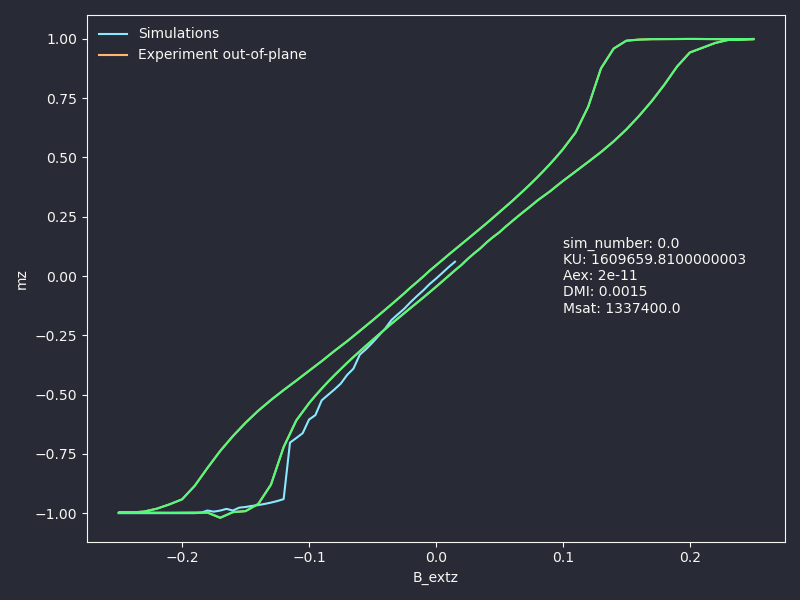

In [11]:
class HysteresisPlotter:
    def __init__(self, data, exdata,i=0):
        self.data = data
        self.exdata = exdata
        self.current_index = 0
        self.fig, self.ax = plt.subplots(figsize=(8, 6))

        self.t1 =self.ax.text(0.1, 0.0, "ABECADLO ", verticalalignment='center', horizontalalignment='left')
        # Aktualizacja parametrów w ramce
        # self.anch = anchored_text = AnchoredText("Test", loc=2)
        # self.ax.add_artist(anchored_text)
        # self.anch.set()
        self.plot_hysteresis(i)
        self.plot_extra_data()  # Rysowanie stałego wykresu

    def plot_extra_data(self):
        # Rysowanie dodatkowego wykresu
        y = self.exdata[:,1] / self.exdata[:,1].max()
        self.ax.plot(self.exdata[:,0], y, label='Experiment out-of-plane')

    def plot_hysteresis(self, sim_number):
        # Filtruj dane dla wybranego numeru symulacji
        subset = self.data[self.data['sim_number'] == sim_number]

        # Tworzenie wykresu histerezy
        self.plot1, = self.ax.plot(subset['B_extz'][::], subset['mz'][::], label='Simulations')
        self.ax.set_xlabel('B_extz')
        self.ax.set_ylabel('mz')
                
        # Rysowanie ponownie stałego wykresu
        self.plot_extra_data()

        # Dodanie legendy
        self.ax.legend()

        # Aktualizacja parametrów w ramce
        self.update_params_inset(subset)

        # Wyświetlanie wykresu
        self.fig.canvas.draw()

    def update_params_inset(self, subset):
        # Dodanie parametrów do ramki
        try:
            params_text = '\n'.join([f'{key}: {round(value,14)}' for key, value in list(subset.iloc[0].to_dict().items())[:-2]])
            self.t1.set_text(params_text)
        except:
            self.t1.set_text("")
        # self.inset.text(0, 0.5, params_text, verticalalignment='center', horizontalalignment='left')

    def update_plot(self, direction):
        subset = self.data[self.data['sim_number'] == direction]

        mz = subset['mz'][::]
        bz = subset['B_extz'][::]
        
        mz_rev = mz*-1
        bz_rev = bz*-1   
        
        mz2 = np.concatenate((mz_rev,mz))
        bz2 = np.concatenate((bz_rev,bz))
        
        self.plot1.set_ydata(mz)
        self.plot1.set_xdata(bz)
        
        # self.plot1.set_ydata(subset['mz'][::])
        # self.plot1.set_xdata(subset['B_extz'][::])

        # Aktualizacja parametrów w ramce
        self.update_params_inset(subset)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
    def save_all_figs(self):
        for i in tqdm(range(self.data['sim_number'].max())[4:]):
            self.update_plot(i)
            plt.savefig(f"./results2/{i}.png")

    def interactive_plot(self):
        interact(self.update_plot, direction=widgets.IntSlider(min=0, max=self.data['sim_number'].max(), step=1, value=0))
%matplotlib widget
plotter = HysteresisPlotter(data.data, exdata)
plotter.interactive_plot()


In [ ]:
plotter = HysteresisPlotter(data.data, exdata)
plotter.interactive_plot()

In [24]:
def calculate_anisotropy_parameter(K_u, M_s):
    """
    Calculate the anisotropy parameter Q for determining the orientation of magnetization.

    Parameters:
    K_u (float): Uniaxial anisotropy constant (J/m^3).
    M_s (float): Saturation magnetization (A/m).

    Returns:
    float: Anisotropy parameter Q.
    """
    mu_0 = 4 * 3.141592653589793 * 1e-7  # Magnetic constant (T·m/A or N·A^-2)

    if M_s == 0:
        raise ValueError("Saturation magnetization M_s must be non-zero.")

    Q = (2 * K_u) / (mu_0 * M_s**2)
    return Q



# Example usage
K = 1125#  Example value for anisotropy constant in J/m^3
M_s = 1388384 # Example value for saturation magnetization in A/m

Q = calculate_anisotropy_parameter(K, M_s)
print("Anisotropy parameter Q:", Q)

Anisotropy parameter Q: 0.0009288668287043046


In [31]:
job = op("/mnt/storage_2/scratch/grant_398/mateuszz/ReCoPt/systematic/v6_new_script/v8_high_ku_3/ku:1755992.52/dind:0.003/msat:1337400.0/sim35_V2_in_plane_backup.zarr")

In [32]:
x = job.table.B_extz[:]
y = job.table.mx[:]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

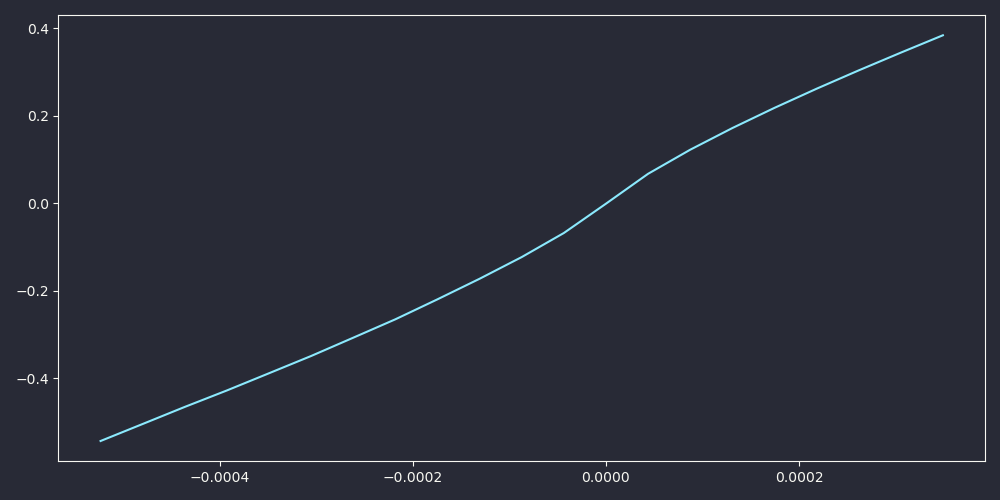

In [ ]:
plt.figure()
plt.plot(x,y)